In [1]:
# this notebook adapts https://github.com/BIGBALLON/CIFAR-ZOO
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from easydict import EasyDict as edict

In [2]:
args = edict()
args.batch_size = 128
args.log_interval = 100
args.data_dir = './data'
args.lr = 0.1
args.momentum = 0.9
args.weight_decay = 0.0001
args.nesterov = True
args.epochs = 150
args.lr_drop_epoch = 50
args.seed = 0
args.no_shuffle = False
print(args)

{'batch_size': 128, 'log_interval': 100, 'data_dir': './data', 'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001, 'nesterov': True, 'epochs': 150, 'lr_drop_epoch': 50, 'seed': 0, 'no_shuffle': False}


In [3]:
def data_augmentation(is_train=True):
    aug = []
    if is_train:
        # random crop
        aug.append(transforms.RandomCrop(32, padding=4))
        # horizontal filp
        aug.append(transforms.RandomHorizontalFlip())

    aug.append(transforms.ToTensor())
    # normalize  [- mean / std]
    aug.append(transforms.Normalize(
        (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)))

    return transforms.Compose(aug)

In [4]:
# fix all seeds for reproducibility
seed = args.seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
def _init_fn(worker_id):
    np.random.seed(int(seed))

In [5]:
use_cuda = True
batch_size = args.batch_size
test_batch_size = args.batch_size

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trainset = datasets.CIFAR10(root=args.data_dir, train=True,
                            download=True, transform=data_augmentation(is_train=True))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=not args.no_shuffle,
                                          worker_init_fn=_init_fn, **kwargs)

testset = datasets.CIFAR10(root=args.data_dir, train=False,
                           download=True, transform=data_augmentation(is_train=False))
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, worker_init_fn=_init_fn,
                                         **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def train(args, model, device, train_loader, optimizer, epoch,
          scheduler=None):
    model.train()
    train_loss = 0
    correct = 0
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        train_loss += loss.item() * data.shape[0]  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            elapsed = time.time() - start_time
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} | ms/batch {:5.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                elapsed * 1000 / args.log_interval))
            start_time = time.time()
        if scheduler is not None:
            scheduler.step()
    train_loss /= len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss, train_acc

In [7]:
def test(args, model, device, test_loader,
         evalmode=True):
    if evalmode:
        model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.bn_1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv_1 = conv3x3(inplanes, planes, stride)
        self.bn_2 = nn.BatchNorm2d(planes)
        self.conv_2 = conv3x3(planes, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn_1(x)
        out = self.relu(out)
        out = self.conv_1(out)

        out = self.bn_2(out)
        out = self.relu(out)
        out = self.conv_2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.bn_1 = nn.BatchNorm2d(inplanes)
        self.conv_1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn_2 = nn.BatchNorm2d(planes)
        self.conv_2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                                padding=1, bias=False)
        self.bn_3 = nn.BatchNorm2d(planes)
        self.conv_3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn_1(x)
        out = self.relu(out)
        out = self.conv_1(out)

        out = self.bn_2(out)
        out = self.relu(out)
        out = self.conv_2(out)

        out = self.bn_3(out)
        out = self.relu(out)
        out = self.conv_3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out


class PreResNet(nn.Module):

    def __init__(self, depth, num_classes=1000, block_name='BasicBlock'):
        super(PreResNet, self).__init__()
        # Model type specifies number of layers for CIFAR-10 model
        if block_name.lower() == 'basicblock':
            assert (
                depth - 2) % 6 == 0, "When use basicblock, depth should be 6n+2, e.g. 20, 32, 44, 56, 110, 1202"
            n = (depth - 2) // 6
            block = BasicBlock
        elif block_name.lower() == 'bottleneck':
            assert (
                depth - 2) % 9 == 0, "When use bottleneck, depth should be 9n+2 e.g. 20, 29, 47, 56, 110, 1199"
            n = (depth - 2) // 9
            block = Bottleneck
        else:
            raise ValueError('block_name shoule be Basicblock or Bottleneck')

        self.inplanes = 16
        self.conv_1 = nn.Conv2d(3, 16, kernel_size=3, padding=1,
                                bias=False)
        self.layer1 = self._make_layer(block, 16, n)
        self.layer2 = self._make_layer(block, 32, n, stride=2)
        self.layer3 = self._make_layer(block, 64, n, stride=2)
        self.bn = nn.BatchNorm2d(64 * block.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False))

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_1(x)   # 32x32

        x = self.layer1(x)   # 32x32
        x = self.layer2(x)   # 16x16
        x = self.layer3(x)   # 8x8
        x = self.bn(x)
        x = self.relu(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def preresnet20(num_classes):
    return PreResNet(depth=20, num_classes=num_classes)


def preresnet32(num_classes):
    return PreResNet(depth=32, num_classes=num_classes)


def preresnet44(num_classes):
    return PreResNet(depth=44, num_classes=num_classes)


def preresnet56(num_classes):
    return PreResNet(depth=56, num_classes=num_classes)


def preresnet110(num_classes):
    return PreResNet(depth=110, num_classes=num_classes)


def preresnet1202(num_classes):
    return PreResNet(depth=1202, num_classes=num_classes)

In [9]:
net = preresnet20(10).to(device)
optimizer = optim.SGD(net.parameters(),
                      lr=args.lr, momentum=args.momentum,
                      weight_decay=args.weight_decay, nesterov=args.nesterov)
scheduler = optim.lr_scheduler.StepLR(optimizer, args.lr_drop_epoch)
logs = []

In [10]:
for epoch in range(1, args.epochs+1):
    epoch_start_time = time.time()
    train_loss, train_acc, = train(args, net, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(args, net, device, test_loader)
    logs.append(dict(
        epoch=epoch,
        train_loss=train_loss,
        train_acc=train_acc,
        valid_loss=test_loss,
        valid_acc=test_acc
    ))
    scheduler.step()
    print('epoch time: {:5.2f}s'.format(time.time() - epoch_start_time))

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.351573 | ms/batch  4.13
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.666974 | ms/batch 39.95
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.554178 | ms/batch 38.06
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.338616 | ms/batch 38.69

Train set: Average loss: 1.5562, Accuracy: 20904/50000 (42%)


Test set: Average loss: 1.8166, Accuracy: 4100/10000 (41%)

epoch time: 18.09s
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.157631 | ms/batch  1.42
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.014064 | ms/batch 37.61
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.046830 | ms/batch 38.12
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.936268 | ms/batch 39.91

Train set: Average loss: 1.0552, Accuracy: 30975/50000 (62%)


Test set: Average loss: 1.1643, Accuracy: 6092/10000 (61%)

epoch time: 17.34s
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.883155 | ms/batch  1.20
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.898303 | ms/batch 41.06
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.823857 | ms/batc

Train Epoch: 21 [12800/50000 (26%)]	Loss: 0.376824 | ms/batch 37.63
Train Epoch: 21 [25600/50000 (51%)]	Loss: 0.431609 | ms/batch 38.10
Train Epoch: 21 [38400/50000 (77%)]	Loss: 0.278847 | ms/batch 39.14

Train set: Average loss: 0.3759, Accuracy: 43517/50000 (87%)


Test set: Average loss: 0.4967, Accuracy: 8349/10000 (83%)

epoch time: 17.88s
Train Epoch: 22 [0/50000 (0%)]	Loss: 0.296364 | ms/batch  1.31
Train Epoch: 22 [12800/50000 (26%)]	Loss: 0.451651 | ms/batch 37.13
Train Epoch: 22 [25600/50000 (51%)]	Loss: 0.329373 | ms/batch 39.79
Train Epoch: 22 [38400/50000 (77%)]	Loss: 0.393776 | ms/batch 36.23

Train set: Average loss: 0.3689, Accuracy: 43544/50000 (87%)


Test set: Average loss: 0.4585, Accuracy: 8473/10000 (85%)

epoch time: 17.06s
Train Epoch: 23 [0/50000 (0%)]	Loss: 0.372866 | ms/batch  1.21
Train Epoch: 23 [12800/50000 (26%)]	Loss: 0.328627 | ms/batch 35.12
Train Epoch: 23 [25600/50000 (51%)]	Loss: 0.375372 | ms/batch 35.35
Train Epoch: 23 [38400/50000 (77%)]	Loss: 0.

Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.271614 | ms/batch 41.13
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.266851 | ms/batch 38.18
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.248098 | ms/batch 37.41

Train set: Average loss: 0.2942, Accuracy: 44871/50000 (90%)


Test set: Average loss: 0.4450, Accuracy: 8553/10000 (86%)

epoch time: 17.61s
Train Epoch: 42 [0/50000 (0%)]	Loss: 0.285103 | ms/batch  1.21
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.290109 | ms/batch 39.39
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.217056 | ms/batch 39.28
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.281620 | ms/batch 37.45

Train set: Average loss: 0.2964, Accuracy: 44865/50000 (90%)


Test set: Average loss: 0.4354, Accuracy: 8587/10000 (86%)

epoch time: 17.60s
Train Epoch: 43 [0/50000 (0%)]	Loss: 0.338562 | ms/batch  1.28
Train Epoch: 43 [12800/50000 (26%)]	Loss: 0.182304 | ms/batch 40.55
Train Epoch: 43 [25600/50000 (51%)]	Loss: 0.397206 | ms/batch 38.19
Train Epoch: 43 [38400/50000 (77%)]	Loss: 0.

Train Epoch: 61 [12800/50000 (26%)]	Loss: 0.119086 | ms/batch 37.01
Train Epoch: 61 [25600/50000 (51%)]	Loss: 0.093487 | ms/batch 36.85
Train Epoch: 61 [38400/50000 (77%)]	Loss: 0.139335 | ms/batch 36.71

Train set: Average loss: 0.1073, Accuracy: 48156/50000 (96%)


Test set: Average loss: 0.2921, Accuracy: 9155/10000 (92%)

epoch time: 16.65s
Train Epoch: 62 [0/50000 (0%)]	Loss: 0.050251 | ms/batch  1.21
Train Epoch: 62 [12800/50000 (26%)]	Loss: 0.077805 | ms/batch 37.32
Train Epoch: 62 [25600/50000 (51%)]	Loss: 0.048939 | ms/batch 36.07
Train Epoch: 62 [38400/50000 (77%)]	Loss: 0.179361 | ms/batch 36.69

Train set: Average loss: 0.1049, Accuracy: 48192/50000 (96%)


Test set: Average loss: 0.2934, Accuracy: 9125/10000 (91%)

epoch time: 16.97s
Train Epoch: 63 [0/50000 (0%)]	Loss: 0.086712 | ms/batch  1.25
Train Epoch: 63 [12800/50000 (26%)]	Loss: 0.075758 | ms/batch 36.16
Train Epoch: 63 [25600/50000 (51%)]	Loss: 0.078333 | ms/batch 36.16
Train Epoch: 63 [38400/50000 (77%)]	Loss: 0.

Train Epoch: 81 [12800/50000 (26%)]	Loss: 0.037002 | ms/batch 40.59
Train Epoch: 81 [25600/50000 (51%)]	Loss: 0.161427 | ms/batch 38.08
Train Epoch: 81 [38400/50000 (77%)]	Loss: 0.084372 | ms/batch 40.05

Train set: Average loss: 0.0741, Accuracy: 48687/50000 (97%)


Test set: Average loss: 0.3326, Accuracy: 9107/10000 (91%)

epoch time: 17.77s
Train Epoch: 82 [0/50000 (0%)]	Loss: 0.041915 | ms/batch  1.31
Train Epoch: 82 [12800/50000 (26%)]	Loss: 0.087731 | ms/batch 38.72
Train Epoch: 82 [25600/50000 (51%)]	Loss: 0.045064 | ms/batch 36.86
Train Epoch: 82 [38400/50000 (77%)]	Loss: 0.053341 | ms/batch 38.98

Train set: Average loss: 0.0712, Accuracy: 48738/50000 (97%)


Test set: Average loss: 0.3272, Accuracy: 9126/10000 (91%)

epoch time: 17.21s
Train Epoch: 83 [0/50000 (0%)]	Loss: 0.062781 | ms/batch  1.27
Train Epoch: 83 [12800/50000 (26%)]	Loss: 0.092927 | ms/batch 37.87
Train Epoch: 83 [25600/50000 (51%)]	Loss: 0.059152 | ms/batch 36.47
Train Epoch: 83 [38400/50000 (77%)]	Loss: 0.

Train Epoch: 101 [12800/50000 (26%)]	Loss: 0.029427 | ms/batch 37.33
Train Epoch: 101 [25600/50000 (51%)]	Loss: 0.033353 | ms/batch 37.67
Train Epoch: 101 [38400/50000 (77%)]	Loss: 0.091244 | ms/batch 39.44

Train set: Average loss: 0.0486, Accuracy: 49219/50000 (98%)


Test set: Average loss: 0.3431, Accuracy: 9160/10000 (92%)

epoch time: 17.55s
Train Epoch: 102 [0/50000 (0%)]	Loss: 0.046357 | ms/batch  1.31
Train Epoch: 102 [12800/50000 (26%)]	Loss: 0.009755 | ms/batch 36.38
Train Epoch: 102 [25600/50000 (51%)]	Loss: 0.063208 | ms/batch 36.18
Train Epoch: 102 [38400/50000 (77%)]	Loss: 0.029104 | ms/batch 35.77

Train set: Average loss: 0.0430, Accuracy: 49320/50000 (99%)


Test set: Average loss: 0.3436, Accuracy: 9160/10000 (92%)

epoch time: 16.53s
Train Epoch: 103 [0/50000 (0%)]	Loss: 0.031463 | ms/batch  1.72
Train Epoch: 103 [12800/50000 (26%)]	Loss: 0.043373 | ms/batch 36.98
Train Epoch: 103 [25600/50000 (51%)]	Loss: 0.033233 | ms/batch 37.32
Train Epoch: 103 [38400/50000 (77%

Train Epoch: 121 [0/50000 (0%)]	Loss: 0.028843 | ms/batch  1.45
Train Epoch: 121 [12800/50000 (26%)]	Loss: 0.033488 | ms/batch 37.79
Train Epoch: 121 [25600/50000 (51%)]	Loss: 0.021906 | ms/batch 40.37
Train Epoch: 121 [38400/50000 (77%)]	Loss: 0.039072 | ms/batch 37.47

Train set: Average loss: 0.0336, Accuracy: 49496/50000 (99%)


Test set: Average loss: 0.3547, Accuracy: 9156/10000 (92%)

epoch time: 17.39s
Train Epoch: 122 [0/50000 (0%)]	Loss: 0.021208 | ms/batch  1.26
Train Epoch: 122 [12800/50000 (26%)]	Loss: 0.024510 | ms/batch 37.61
Train Epoch: 122 [25600/50000 (51%)]	Loss: 0.040122 | ms/batch 39.10
Train Epoch: 122 [38400/50000 (77%)]	Loss: 0.023635 | ms/batch 37.53

Train set: Average loss: 0.0334, Accuracy: 49491/50000 (99%)


Test set: Average loss: 0.3549, Accuracy: 9173/10000 (92%)

epoch time: 17.25s
Train Epoch: 123 [0/50000 (0%)]	Loss: 0.014201 | ms/batch  1.33
Train Epoch: 123 [12800/50000 (26%)]	Loss: 0.011899 | ms/batch 38.09
Train Epoch: 123 [25600/50000 (51%)]	Lo


Test set: Average loss: 0.3570, Accuracy: 9167/10000 (92%)

epoch time: 16.42s
Train Epoch: 141 [0/50000 (0%)]	Loss: 0.036810 | ms/batch  1.59
Train Epoch: 141 [12800/50000 (26%)]	Loss: 0.010857 | ms/batch 36.88
Train Epoch: 141 [25600/50000 (51%)]	Loss: 0.028449 | ms/batch 36.64
Train Epoch: 141 [38400/50000 (77%)]	Loss: 0.024164 | ms/batch 35.95

Train set: Average loss: 0.0306, Accuracy: 49559/50000 (99%)


Test set: Average loss: 0.3579, Accuracy: 9159/10000 (92%)

epoch time: 16.84s
Train Epoch: 142 [0/50000 (0%)]	Loss: 0.031406 | ms/batch  1.28
Train Epoch: 142 [12800/50000 (26%)]	Loss: 0.029680 | ms/batch 37.32
Train Epoch: 142 [25600/50000 (51%)]	Loss: 0.018100 | ms/batch 36.14
Train Epoch: 142 [38400/50000 (77%)]	Loss: 0.013627 | ms/batch 36.89

Train set: Average loss: 0.0290, Accuracy: 49579/50000 (99%)


Test set: Average loss: 0.3597, Accuracy: 9161/10000 (92%)

epoch time: 16.64s
Train Epoch: 143 [0/50000 (0%)]	Loss: 0.043621 | ms/batch  1.25
Train Epoch: 143 [12800/5000

In [11]:
logdf = pd.DataFrame(logs)

In [12]:
def tight_layout(fig):
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [13]:
best_loss_epoch, best_loss = logdf.sort_values(by='valid_loss')[['epoch', 'valid_loss']].to_numpy()[0]
best_acc_epoch, best_acc = logdf.sort_values(by='valid_acc', ascending=False)[['epoch', 'valid_acc']].to_numpy()[0]
print(f'Best validation loss is {best_loss:.4f}, achieved at epoch {int(best_loss_epoch)}.\n'
      f'But best validation accuracy is {best_acc}, achieved much later at epoch {int(best_acc_epoch)}.')

Best validation loss is 0.2769, achieved at epoch 52.
But best validation accuracy is 0.9185, achieved much later at epoch 112.


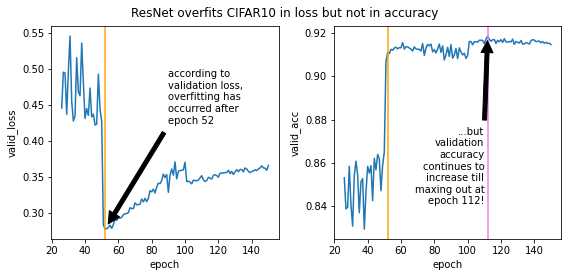

In [14]:
df = logdf[logdf.epoch > 25]
plt.figure(figsize=(8, 4))
plt.subplot(121)
sns.lineplot(data=df, x='epoch', y='valid_loss')
plt.axvline(best_loss_epoch, c='orange')
plt.annotate(f'according to\nvalidation loss,\noverfitting has\noccurred after\nepoch {int(best_loss_epoch)}',
            xy=(best_loss_epoch, best_loss),  xycoords='data',
            xytext=(90, 0.5), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='top',
             wrap=True
            )
plt.subplot(122)
sns.lineplot(data=df, x='epoch', y='valid_acc')
plt.axvline(best_loss_epoch, c='orange')
plt.axvline(best_acc_epoch, c='violet')
plt.annotate(f'...but\nvalidation\naccuracy\ncontinues to\nincrease till\nmaxing out at\nepoch {int(best_acc_epoch)}!',
            xy=(best_acc_epoch, best_acc),  xycoords='data',
            xytext=(110, 0.84), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',
             wrap=True
            )
plt.suptitle('ResNet overfits CIFAR10 in loss but not in accuracy')
tight_layout(plt)
plt.savefig('resnet.png', dpi=200, bbox_inches='tight')